In [1]:
# ---------- Full production training + OOF + stacking cell ----------
# Paste into your notebook. Adjust flags/budgets below before running.
import os, time, math, json, warnings
from pathlib import Path
from typing import Dict, Tuple, Any
import numpy as np, pandas as pd
from tqdm.notebook import tqdm
from joblib import dump, load
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
import importlib

warnings.filterwarnings("ignore")

# ---------------- CONFIG ----------------
PROJECT_ROOT = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS")
DATA_EXTENDED = PROJECT_ROOT / "data" / "surface-air-temperature-monthly-mean-extended.csv"
MODELS_DIR = PROJECT_ROOT / "results" / "models"
ARTIFACTS_DIR = MODELS_DIR / "artifacts"
CSV_DIR = PROJECT_ROOT / "results" / "csv_files"
FIG_DIR = PROJECT_ROOT / "results" / "figures"
for d in (MODELS_DIR, ARTIFACTS_DIR, CSV_DIR, FIG_DIR):
    Path(d).mkdir(parents=True, exist_ok=True)

# Toggle which heavy modules to run (set False to skip)
ENABLE_H2O = True
ENABLE_TPOT = False      # TPOT is very slow; set True only if you have time
ENABLE_AUTOGLUON = False
ENABLE_TORCH_FORECAST = False  # TFT / N-BEATS — heavy; requires GPU ideally
ENABLE_GLUONTS = False   # DeepAR (requires gluonts and mxnet)
ENABLE_TCN = False       # Keras/TensorFlow-based TCN
ENABLE_OPTUNA_META = True

# Budgets (adjust to compute resources)
BUDGET_H2O_SECONDS = 600         # H2O AutoML budget per overall run (will split if per-fold)
TPOT_GENERATIONS = 8
TPOT_POPULATION = 40
AUTOGLUON_TIME = 600             # seconds
TFT_EPOCHS = 30
NBEATS_EPOCHS = 50
DEEPAR_EPOCHS = 20
TCN_EPOCHS = 25

# CV settings
N_SPLITS = 5    # TimeSeriesSplit folds for OOF
RANDOM_STATE = 42

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_EXTENDED:", DATA_EXTENDED)
print("MODELS_DIR:", MODELS_DIR)

PROJECT_ROOT: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS
DATA_EXTENDED: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\data\surface-air-temperature-monthly-mean-extended.csv
MODELS_DIR: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models


In [2]:
# Preflight: check environment, java (for H2O), and auto-install key libs (safe defaults).
import sys, subprocess, shutil, os, importlib, platform
from pathlib import Path

def pip_install(pkg):
    print("Installing:", pkg)
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# Java check (for H2O)
def java_ok():
    java = shutil.which("java")
    if java:
        try:
            out = subprocess.check_output([java, "-version"], stderr=subprocess.STDOUT)
            print("Java available:", out.decode(errors="ignore").splitlines()[0])
            return True
        except Exception:
            return False
    else:
        print("Java not found on PATH.")
        return False

print("Platform:", platform.platform())
print("Python:", sys.version.splitlines()[0])
print("Checking Java (needed for H2O):")
_has_java = java_ok()

# Libraries we may need — conservative list for the snippets below
required = {
    "h2o": "h2o",
    "tpot": "tpot",
    "optuna": "optuna",
    "autogluon.tabular": "autogluon.tabular",
    "xgboost": "xgboost",
    "pytorch_lightning": "pytorch-lightning",
    "pytorch_forecasting": "pytorch-forecasting",
    "gluonts": "gluonts",
    "tensorflow": "tensorflow",
    "mapie": "mapie",            # conformal methods (simple)
    "scikit-learn": "scikit-learn",
}

# Try importing; if not installed, attempt to pip install the package name
for mod, pipname in required.items():
    try:
        importlib.import_module(mod)
        print(f"OK: {mod}")
    except Exception:
        print(f"Missing: {mod} -> attempting to install {pipname}")
        try:
            pip_install(pipname)
        except Exception as e:
            print(f"Failed to install {pipname}: {e}")

print("\nSummary: Java OK =", _has_java)
print("If H2O will be used, ensure Java (OpenJDK 11+) is installed and on PATH.")
print("If auto-install errors occur, run the failing pip commands manually in a terminal.")


Platform: Windows-10-10.0.26100-SP0
Python: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
Checking Java (needed for H2O):
Java available: java version "11.0.26" 2025-01-21 LTS
Missing: h2o -> attempting to install h2o
Installing: h2o
Missing: tpot -> attempting to install tpot
Installing: tpot
OK: optuna
Missing: autogluon.tabular -> attempting to install autogluon.tabular
Installing: autogluon.tabular
OK: xgboost
OK: pytorch_lightning
OK: pytorch_forecasting
OK: gluonts
OK: tensorflow
OK: mapie
Missing: scikit-learn -> attempting to install scikit-learn
Installing: scikit-learn

Summary: Java OK = True
If H2O will be used, ensure Java (OpenJDK 11+) is installed and on PATH.
If auto-install errors occur, run the failing pip commands manually in a terminal.


### H2O AutoML (small-budget example)

In [4]:
# H2O AutoML (robust + installs xgboost if missing + pandas to_csv fallback)
import os, sys, subprocess, warnings, csv, time
from pathlib import Path

# ------- Config -------
PROJECT_ROOT = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS")
DATA_EXTENDED = PROJECT_ROOT / "data" / "surface-air-temperature-monthly-mean-extended.csv"
MODELS_DIR = PROJECT_ROOT / "results" / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

H2O_MAX_MEM = "4G"
AUTOML_SECONDS = 120
RANDOM_SEED = 42

# ------- Helpers -------
def pip_install(pkg):
    try:
        print(f"Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        print(f"Installed {pkg}.")
    except Exception as e:
        print(f"Failed to install {pkg}: {e}")
        raise

def safe_import(pkg_name, install_name=None):
    try:
        module = __import__(pkg_name)
        return module
    except Exception:
        if install_name is None:
            install_name = pkg_name
        pip_install(install_name)
        module = __import__(pkg_name)
        return module

# ------- 0) Ensure xgboost is installed for H2O to attempt XGBoost models -------
try:
    import xgboost
    print("xgboost already available.")
except Exception:
    print("xgboost not found — attempting to install (this may take a while)...")
    pip_install("xgboost")
    try:
        import xgboost
        print("xgboost installed successfully.")
    except Exception as e:
        print("xgboost install failed or not importable:", e)
        # Continue anyway; H2O will skip XGBoost if backend not available.

# ------- 1) load df_ext if needed -------
import pandas as pd
import numpy as np

if 'df_ext' in globals() and isinstance(globals()['df_ext'], pd.DataFrame):
    df_ext = globals()['df_ext']
    print("Using df_ext already in notebook (shape:", df_ext.shape, ")")
else:
    if not DATA_EXTENDED.exists():
        raise FileNotFoundError(f"Extended CSV not found at {DATA_EXTENDED}")
    print("Loading extended CSV:", DATA_EXTENDED)
    df_ext = pd.read_csv(DATA_EXTENDED, low_memory=False)
    print("Loaded df_ext shape:", df_ext.shape)

# ensure target
if 'mean_temp' not in df_ext.columns and 'mean temperature' in df_ext.columns:
    df_ext['mean_temp'] = df_ext['mean temperature']
if 'mean_temp' not in df_ext.columns:
    raise RuntimeError("Target column 'mean_temp' not found in df_ext. Please add it and re-run.")

# ------- 2) create safe lag features (no leakage) -------
def make_safe_lag_feats(df, target_col='mean_temp', lags=(1,2,3,12), add_month_cyclic=True):
    s = pd.to_numeric(df[target_col], errors='coerce').astype(float)
    X = pd.DataFrame(index=df.index)
    for lag in lags:
        X[f"lag_{lag}"] = s.shift(lag)
    X['roll_mean_3'] = s.shift(1).rolling(3, min_periods=1).mean()
    X['ewm_12'] = s.shift(1).ewm(span=12, adjust=False).mean()
    # month cyclic if available
    months = None
    try:
        months = pd.to_datetime(df.index).month
    except Exception:
        for c in ('month','date','datetime','ds','time','timestamp'):
            if c in df.columns:
                try:
                    months = pd.to_datetime(df[c], errors='coerce').dt.month
                    break
                except Exception:
                    months = None
    if add_month_cyclic and months is not None:
        m = months.fillna(0).astype(int).values
        X['month_sin'] = np.sin(2*np.pi*m/12)
        X['month_cos'] = np.cos(2*np.pi*m/12)
    y = s.copy()
    return X, y

print("Building lag-only (leakage-free) features...")
X_safe, y_safe = make_safe_lag_feats(df_ext, target_col='mean_temp', lags=(1,2,3,12), add_month_cyclic=True)
df_model = pd.concat([X_safe, y_safe.rename('mean_temp')], axis=1)
before = len(df_model)
df_model = df_model.dropna(axis=0, how='any').reset_index(drop=True)
after = len(df_model)
print(f"Dropped {before-after} rows due to lagging. Rows available for AutoML: {after}")
if after < 20:
    raise RuntimeError("Too few rows after lagging to run AutoML. Need more data or reduce lags.")

# ------- 3) import and init H2O -------
try:
    import h2o
    from h2o.automl import H2OAutoML
except Exception:
    print("h2o not installed; attempting to install h2o...")
    pip_install("h2o")
    import h2o
    from h2o.automl import H2OAutoML

# quick Java check (informational)
try:
    java_check = os.popen("java -version 2>&1").read()
    if java_check.strip() == "":
        print("Warning: 'java -version' returned nothing — ensure Java 11+ is installed and JAVA_HOME is set.")
    else:
        # print first line
        print("Java present:", java_check.splitlines()[0])
except Exception:
    print("Could not run 'java -version' check — ensure Java 11+ on PATH/JAVA_HOME for H2O XGBoost.")

print("Starting H2O with max_mem_size=", H2O_MAX_MEM)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    h2o.init(max_mem_size=H2O_MAX_MEM, nthreads=1)

# ------- 4) convert data & run AutoML -------
hf = h2o.H2OFrame(df_model)
target = "mean_temp"
features = [c for c in hf.columns if c != target]

print("H2O frame: rows =", hf.nrows, "cols =", hf.ncols)
print("Running H2O AutoML for", AUTOML_SECONDS, "seconds on features:", features)

aml = H2OAutoML(
    max_runtime_secs=int(AUTOML_SECONDS),
    seed=RANDOM_SEED,
    include_algos=["GBM","XGBoost","GLM","StackedEnsemble"],
    max_models=12
)

try:
    aml.train(x=features, y=target, training_frame=hf)
except Exception as e:
    print("H2O AutoML training failed:", e)
    try:
        h2o.shutdown(prompt=False)
    except Exception:
        pass
    raise

# ------- 5) Save leaderboard robustly (avoid pandas.to_csv bug) -------
try:
    lb_df = aml.leaderboard.as_data_frame()   # attempt to get pandas DF
    print("Leaderboard fetched (pandas DataFrame). Top rows:")
    print(lb_df.head(10))
    # write CSV via csv module (avoid pandas.to_csv internals)
    lb_path = MODELS_DIR / "h2o_leaderboard.csv"
    with open(lb_path, "w", newline="", encoding="utf-8") as fh:
        writer = csv.writer(fh)
        writer.writerow(list(lb_df.columns))
        for row in lb_df.itertuples(index=False, name=None):
            writer.writerow([("" if v is None else v) for v in row])
    print("Saved leaderboard (csv writer fallback) ->", lb_path)
except Exception as e:
    # last resort: try h2o's export function
    print("Could not write leaderboard with pandas/csv fallback:", e)
    try:
        tmp_path = MODELS_DIR / "h2o_leaderboard_h2o.csv"
        h2o.export_file(aml.leaderboard, path=str(tmp_path), force=True)
        print("Saved leaderboard via h2o.export_file ->", tmp_path)
    except Exception as e2:
        print("Failed to save leaderboard via h2o.export_file as well:", e2)

# ------- 6) save leader model and try MOJO -------
try:
    leader = aml.leader
    model_saved_path = h2o.save_model(leader, path=str(MODELS_DIR), filename="h2o_leader", force=True)
    print("Saved H2O leader model to:", model_saved_path)
    try:
        mojo_path = h2o.download_mojo(leader, path=str(MODELS_DIR))
        print("Saved MOJO to:", mojo_path)
    except Exception as e:
        print("Could not create MOJO (this may be fine):", e)
except Exception as e:
    print("Failed to save H2O leader model:", e)

# ------- 7) cleanup -------
print("Shutting down H2O ...")
try:
    h2o.shutdown(prompt=False)
    # small pause so JVM cleans up
    time.sleep(2)
except Exception as e:
    print("H2O shutdown warning:", e)

print("Done. Models and leaderboard (if created) are in:", MODELS_DIR)


xgboost already available.
Using df_ext already in notebook (shape: (449, 32) )
Building lag-only (leakage-free) features...
Dropped 12 rows due to lagging. Rows available for AutoML: 437
Java present: java version "11.0.26" 2025-01-21 LTS
Starting H2O with max_mem_size= 4G
Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,18 mins 54 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,5 months and 22 days
H2O_cluster_name:,H2O_from_python_soura_y2ai1z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.995 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
H2O frame: rows = 437 cols = 9
Running H2O AutoML for 120 seconds on features: ['lag_1', 'lag_2', 'lag_3', 'lag_12', 'roll_mean_3', 'ewm_12', 'month_sin', 'month_cos']
AutoML progress: |█
20:09:32.977: AutoML: XGBoost is not available; skipping it.
20:09:33.3: _train param, Dropping bad and constant columns: [month_sin, month_cos]
20:09:33.626: _train param, Dropping bad and constant columns: [month_sin, month_cos]
20:09:34.976: _train param, Dropping bad and constant columns: [month_sin, month_cos]
20:09:35.860: _train param, Dropping bad and constant columns: [month_sin, month_cos]
20:09:36.804: _train param, Dropping bad and constant columns: [month_sin, month_cos]

██
20:09:39.0: _train param, Dropping bad and constant columns: [month_sin, month_cos]

██████████████
20:09:46.631: _train param, Dropping unused columns: [month_sin, month_cos]
20:09:47.789: _train param, Dropping unused colu

e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Leaderboard fetched (pandas DataFrame). Top rows:
                                            model_id      rmse       mse  \
0  StackedEnsemble_AllModels_1_AutoML_2_20250918_...  0.472950  0.223682   
1  StackedEnsemble_BestOfFamily_1_AutoML_2_202509...  0.475729  0.226318   
2                     GLM_1_AutoML_2_20250918_200932  0.481428  0.231773   
3                     GBM_2_AutoML_2_20250918_200932  0.485248  0.235465   
4        GBM_grid_1_AutoML_2_20250918_200932_model_4  0.486476  0.236659   
5                     GBM_3_AutoML_2_20250918_200932  0.488322  0.238459   
6        GBM_grid_1_AutoML_2_20250918_200932_model_5  0.491765  0.241833   
7        GBM_grid_1_AutoML_2_20250918_200932_model_2  0.492195  0.242256   
8                     GBM_4_AutoML_2_20250918_200932  0.492398  0.242456   
9        GBM_grid_1_AutoML_2_20250918_200932_model_1  0.494947  0.244973   

        mae     rmsle  mean_residual_deviance  
0  0.379120  0.016518                0.223682  
1  0.381407  0.01

C:\Users\soura\AppData\Local\Temp\ipykernel_19968\2705222814.py:197: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown(prompt=False)


H2O session _sid_a9fe closed.
Done. Models and leaderboard (if created) are in: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models


### TPOT (small-budget evolutionary pipeline search)

In [7]:
# Robust TPOT installer + small-run executor for notebooks
# Paste this whole cell into a notebook and run.
import sys, os, time, subprocess, importlib, traceback
from pathlib import Path

# ================= CONFIG =================
PROJECT_ROOT = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS")
DATA_CSV = PROJECT_ROOT / "data" / "surface-air-temperature-monthly-mean-extended.csv"
MODELS_DIR = PROJECT_ROOT / "results" / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Safety switch - set True to skip any automatic install attempts
SKIP_AUTO_INSTALL = False

# TPOT runtime budget (small by default)
TPOT_GENERATIONS = 3
TPOT_POP_SIZE = 20

# Candidate pyarrow versions that often fix PyExtensionType ABI issues.
PYARROW_CANDIDATES = ["12.0.1","11.0.0","13.0.0"]

# ==========================================

def run_cmd(cmd, show_output=False):
    """Run a shell command and capture output (returns (code, output))."""
    try:
        proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
        out_lines = []
        for line in proc.stdout:
            out_lines.append(line)
            if show_output:
                print(line, end="")
        proc.wait()
        return proc.returncode, "".join(out_lines)
    except Exception as e:
        return 1, f"Exception while running {cmd}: {e}"

def pip_install(pkgs):
    """Install packages using pip. pkgs: list of strings."""
    cmd = [sys.executable, "-m", "pip", "install", *pkgs]
    print(">>> Running pip:", " ".join(cmd))
    code, out = run_cmd(cmd, show_output=False)
    print(out[:4000])
    return code == 0

def try_import(modname):
    """Try to import module; return (ok, object_or_exception)."""
    try:
        mod = importlib.import_module(modname)
        return True, mod
    except Exception as e:
        return False, e

# ----------------- Step A: Quick import checks -----------------
print("=== TPOT/pyarrow health-check ===")
tp_ok, tp_obj = try_import("tpot")
pa_ok, pa_obj = try_import("pyarrow.lib")

print("TPOT import OK:", tp_ok)
print("pyarrow.lib import OK:", pa_ok)
if pa_ok:
    has_ext = hasattr(pa_obj, "PyExtensionType")
    print("pyarrow.lib has PyExtensionType:", has_ext)
else:
    print("pyarrow.lib import error:", tp_obj if not pa_ok else "")

# If TPOT already importable, just run small job
if tp_ok:
    print("TPOT is already importable. Skipping install steps.")
else:
    if SKIP_AUTO_INSTALL:
        print("SKIP_AUTO_INSTALL=True -> skipping automatic pip attempts. Please install TPOT manually (conda recommended).")
    else:
        # If pyarrow exists but missing PyExtensionType, try reinstalling compatible pyarrow
        if pa_ok and not hasattr(pa_obj, "PyExtensionType"):
            print("\npyarrow present but missing PyExtensionType -> attempting to reinstall a compatible pyarrow...")
            for ver in PYARROW_CANDIDATES:
                print(f"Attempting pip install pyarrow=={ver} ...")
                success = pip_install([f"pyarrow=={ver}"])
                time.sleep(1.0)
                importlib.invalidate_caches()
                pa_ok2, pa_obj2 = try_import("pyarrow.lib")
                if pa_ok2 and hasattr(pa_obj2, "PyExtensionType"):
                    print("Success: pyarrow now has PyExtensionType:", ver)
                    break
                else:
                    print(f"pyarrow=={ver} did not fix it (or import still fails).")
            else:
                print("\nAutomatic pyarrow attempts failed. Recommended: use conda-forge to install pyarrow/pandas/dask/tpot.")
                print("Example (run in terminal):")
                print("  conda create -n airtemp python=3.10 -y")
                print("  conda activate airtemp")
                print("  conda install -c conda-forge pyarrow pandas dask tpot -y")
        # If pyarrow not installed at all, try to install pyarrow then TPOT
        elif not pa_ok:
            print("\npyarrow not installed — attempting pip install pyarrow (candidate versions)...")
            for ver in PYARROW_CANDIDATES:
                print(f"Attempting pip install pyarrow=={ver} ...")
                pip_install([f"pyarrow=={ver}"])
                time.sleep(0.8)
                importlib.invalidate_caches()
                pa_ok2, pa_obj2 = try_import("pyarrow.lib")
                if pa_ok2 and hasattr(pa_obj2, "PyExtensionType"):
                    print("Success: installed pyarrow", ver)
                    break
            else:
                print("pyarrow install attempts failed or pyarrow still incompatible. Try conda install -c conda-forge pyarrow.")

        # Try installing TPOT now
        print("\nAttempting pip install tpot and its required deps (deap, update_checker)...")
        pip_install(["tpot", "deap", "update_checker"])
        time.sleep(1.0)
        importlib.invalidate_caches()
        tp_ok2, tp_obj2 = try_import("tpot")
        if tp_ok2:
            print("TPOT imported successfully after installs.")
        else:
            print("TPOT still not importable. Error:", tp_obj2)
            print("\nManual recommendations (Windows):")
            print("  1) Use conda-forge: conda install -c conda-forge tpot")
            print("  2) Or install in WSL / Linux environment.")
            print("  3) If pip builds fail, install Visual C++ Build Tools on Windows.")
            print("\nIf you installed packages just now, PLEASE RESTART THE JUPYTER KERNEL and run this cell again.")
            # Do not crash — continue but skip TPOT run
            tp_ok = False
        # set final flag
        tp_ok = tp_ok or tp_ok2

# ----------------- Step B: If TPOT available -> run a small safe job -----------------
if tp_ok:
    print("\n=== TPOT available: running a small safe TPOT job (budget small) ===")
    try:
        # import inside try
        from tpot import TPOTRegressor
        from sklearn.model_selection import TimeSeriesSplit
        import numpy as np
        import pandas as pd
        from joblib import dump

        # Use existing X_all, y_all if present in notebook globals
        g = globals()
        if 'X_all' in g and 'y_all' in g:
            X = g['X_all'].copy()
            y = g['y_all'].copy()
            print("Using existing X_all/y_all from notebook.")
        else:
            # fallback: build simple leakage-free features from extended CSV
            if not DATA_CSV.exists():
                raise FileNotFoundError(f"Data CSV not found at {DATA_CSV}")
            df_ext = pd.read_csv(DATA_CSV, low_memory=False)
            if 'mean_temp' not in df_ext.columns and 'mean temperature' in df_ext.columns:
                df_ext['mean_temp'] = df_ext['mean temperature']
            if 'mean_temp' not in df_ext.columns:
                raise RuntimeError("Target 'mean_temp' not found in CSV.")
            s = pd.to_numeric(df_ext['mean_temp'], errors='coerce')
            # build simple lag+rolling features (leakage-free)
            def build_quick_features(series):
                series = series.reset_index(drop=True)
                N = len(series)
                Xtmp = pd.DataFrame(index=range(N))
                for lag in [1,2,3,12]:
                    Xtmp[f"lag_{lag}"] = series.shift(lag)
                for w in [3,6,12]:
                    Xtmp[f"roll_mean_{w}"] = series.shift(1).rolling(w, min_periods=1).mean()
                Xtmp = Xtmp.fillna(method='ffill').fillna(0.0).astype(float)
                return Xtmp, series.fillna(method='ffill').fillna(0.0).astype(float)
            X, y = build_quick_features(s)

        # ensure numeric and drop any incomplete rows
        mask = ~X.isna().any(axis=1)
        X2 = X.loc[mask].reset_index(drop=True)
        y2 = y.loc[mask].reset_index(drop=True)

        if len(X2) < 40:
            print("Too few rows for a sensible TPOT run (after cleaning). Need >=40. Skipping TPOT run.")
        else:
            # small time-series cross-validation
            n_splits = min(3, max(2, len(X2)//50))
            tscv = TimeSeriesSplit(n_splits=n_splits)
            tpot = TPOTRegressor(
                generations=TPOT_GENERATIONS,
                population_size=TPOT_POP_SIZE,
                verbosity=2,
                n_jobs=-1,
                cv=tscv,
                scoring='neg_root_mean_squared_error',
                random_state=42
            )
            print(f"Starting TPOT: generations={TPOT_GENERATIONS}, pop_size={TPOT_POP_SIZE}, cv_splits={n_splits}")
            tpot.fit(X2, y2)
            # export and save
            export_py = MODELS_DIR / "tpot_exported_pipeline.py"
            joblib_path = MODELS_DIR / "tpot_fitted_pipeline.joblib"
            try:
                tpot.export(str(export_py))
            except Exception as e:
                print("Warning: tpot.export failed:", e)
            from joblib import dump as jb_dump
            jb_dump(tpot.fitted_pipeline_, str(joblib_path))
            print("TPOT completed. Exported pipeline ->", export_py)
            print("Saved fitted pipeline ->", joblib_path)
    except Exception as e:
        print("TPOT run failed: ", e)
        traceback.print_exc()
else:
    print("\nTPOT is not available. The notebook will continue; TPOT steps skipped.")
    print("Recommended manual fix (conda) to avoid these repeated issues:")
    print("  conda create -n airtemp python=3.10 -y")
    print("  conda activate airtemp")
    print("  conda install -c conda-forge pyarrow pandas dask tpot -y")
    print("Or run the pip commands printed earlier and then restart the kernel.")

print("\nCell finished. If installs were performed, restart the Jupyter kernel before importing TPOT in new cells.")


=== TPOT/pyarrow health-check ===
TPOT import OK: False
pyarrow.lib import OK: True
pyarrow.lib has PyExtensionType: False

pyarrow present but missing PyExtensionType -> attempting to reinstall a compatible pyarrow...
Attempting pip install pyarrow==12.0.1 ...
>>> Running pip: e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\Scripts\python.exe -m pip install pyarrow==12.0.1
   ---------------------------------------- 0.0/21.5 MB ? eta -:--:--
   - -------------------------------------- 1.0/21.5 MB 12.5 MB/s eta 0:00:02
   --- ------------------------------------ 2.1/21.5 MB 5.9 MB/s eta 0:00:04
   --- ------------------------------------ 2.1/21.5 MB 5.9 MB/s eta 0:00:04
   --- ------------------------------------ 2.1/21.5 MB 5.9 MB/s eta 0:00:04
   ----- ---------------------------------- 3.1/21.5 MB 3.1 MB/s eta 0:00:06
   ------- -------------------------------- 4.2/21.5 MB 3.2 MB/s eta 0:00:06
   --------- ------------------------------ 5.2/21.5 MB 3.9 M

In [8]:
# Robust TPOT run with automatic fallback for "No valid workers found"
import os, time, warnings, traceback
from pathlib import Path
import pandas as pd
import numpy as np

PROJECT_ROOT = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS")
DATA_CSV = PROJECT_ROOT / "data" / "surface-air-temperature-monthly-mean-extended.csv"
MODELS_DIR = PROJECT_ROOT / "results" / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

TPOT_GENERATIONS = 3
TPOT_POP_SIZE = 20
CV_SPLITS = 3
RANDOM_STATE = 42

# --- load/build features (use existing X_all/y_all if present) ---
if "X_all" in globals() and "y_all" in globals():
    X_all = globals()["X_all"]
    y_all = globals()["y_all"]
    print("Using existing X_all/y_all from notebook.")
else:
    if not DATA_CSV.exists():
        raise FileNotFoundError(f"data CSV not found: {DATA_CSV}")
    df = pd.read_csv(DATA_CSV, low_memory=False)
    if 'mean_temp' not in df.columns and 'mean temperature' in df.columns:
        df['mean_temp'] = df['mean temperature']
    if 'mean_temp' not in df.columns:
        raise RuntimeError("mean_temp column missing in CSV.")
    y_series = pd.to_numeric(df['mean_temp'], errors='coerce').astype(float).reset_index(drop=True)

    def make_quick_features(series):
        X = pd.DataFrame(index=range(len(series)))
        for lag in [1,2,3,12]:
            X[f"lag_{lag}"] = series.shift(lag)
        for w in [3,6,12]:
            X[f"roll_mean_{w}"] = series.shift(1).rolling(w, min_periods=1).mean()
        # use ffill then fill remaining zeros (avoids deprecated fillna(method=...))
        X = X.ffill().fillna(0.0).astype(float)
        return X.reset_index(drop=True)

    X_all = make_quick_features(y_series)
    y_all = y_series.ffill().fillna(0.0).astype(float).reset_index(drop=True)
    print("Built quick features. X_all shape:", X_all.shape, "y_all len:", len(y_all))

# basic sanity
if len(X_all) < (CV_SPLITS + 2):
    raise RuntimeError(f"Not enough rows for TPOT CV: need >= {CV_SPLITS+2}, got {len(X_all)}")

# --- try imports ---
try:
    from tpot import TPOTRegressor
    from sklearn.model_selection import TimeSeriesSplit
    import joblib
except Exception as e:
    raise RuntimeError("TPOT import failed. If you installed TPOT/pyarrow just now, restart the kernel and re-run this cell.") from e

tscv = TimeSeriesSplit(n_splits=CV_SPLITS)

# --- helper to attempt TPOT fit, with retry fallback ---
def attempt_tpot_fit(X, y, tpot_kwargs, try_dask_cluster=False):
    """
    Tries to run TPOT with given kwargs. If try_dask_cluster=True, will attempt to
    create a LocalCluster and Client dynamically (if dask is installed).
    Returns: fitted_tpot instance or raises.
    """
    cluster_client = None
    created_cluster = False
    # optionally attempt to create a local dask cluster (only if dask is installed)
    if try_dask_cluster:
        try:
            from dask.distributed import LocalCluster, Client
            cpu = max(1, (os.cpu_count() or 1) - 1)
            n_workers = min(4, cpu) if cpu>1 else 1
            cluster = LocalCluster(n_workers=n_workers, threads_per_worker=1, processes=True, dashboard_address=None)
            client = Client(cluster)
            cluster_client = client
            created_cluster = True
            print(f"Started LocalCluster with {n_workers} worker(s). Dask client: {client}")
            # Some TPOT versions will auto-detect active dask client; leave tpot_kwargs.n_jobs as-is.
        except Exception as e:
            print("Could not start LocalCluster/Client (dask). Proceeding without Dask. Reason:", e)
            cluster_client = None
            created_cluster = False

    # Construct TPOT safely (avoid passing unsupported kwargs)
    try:
        tpot = TPOTRegressor(**tpot_kwargs)
    except TypeError as e:
        # fallback: remove any unknown/unsupported args (very defensive)
        print("TPOT constructor raised TypeError; retrying with minimal args. Exception:", e)
        minimal = {
            "generations": tpot_kwargs.get("generations", 3),
            "population_size": tpot_kwargs.get("population_size", 20),
            "cv": tpot_kwargs.get("cv", CV_SPLITS),
            "n_jobs": tpot_kwargs.get("n_jobs", 1),
            "random_state": tpot_kwargs.get("random_state", RANDOM_STATE),
        }
        tpot = TPOTRegressor(**minimal)

    # attempt fit
    try:
        tpot.fit(X, y)
        return tpot, cluster_client
    except Exception as err:
        # Clean up cluster if created
        if created_cluster and cluster_client is not None:
            try:
                cluster_client.close()
            except Exception:
                pass
        # bubble up exception
        raise err

# --- Primary try 1: try with parallel n_jobs=-1 (let TPOT choose / use dask if available) ---
tpot = None
cluster_client = None
first_try_kwargs = {
    "generations": TPOT_GENERATIONS,
    "population_size": TPOT_POP_SIZE,
    "cv": tscv,            # pass TimeSeriesSplit object if supported
    "n_jobs": -1,          # attempt parallelism
    "random_state": RANDOM_STATE,
}

print("Attempting TPOT with parallelism (n_jobs=-1). Will try to start a LocalCluster if needed.")
try:
    tpot, cluster_client = attempt_tpot_fit(X_all, y_all, first_try_kwargs, try_dask_cluster=True)
    print("TPOT fit succeeded with parallelism.")
except Exception as e_par:
    # If the known "No valid workers found" or other dask errors occur, retry with n_jobs=1
    msg = str(e_par)
    print("Parallel TPOT attempt failed. Exception summary:", msg)
    if "No valid workers found" in msg or "No workers" in msg or isinstance(e_par, RuntimeError) or isinstance(e_par, Exception):
        print("Retrying TPOT with n_jobs=1 (single-worker fallback). This avoids Dask worker issues.")
        try:
            fallback_kwargs = {
                "generations": TPOT_GENERATIONS,
                "population_size": TPOT_POP_SIZE,
                "cv": CV_SPLITS,   # simpler int fallback
                "n_jobs": 1,
                "random_state": RANDOM_STATE,
            }
            tpot, cluster_client = attempt_tpot_fit(X_all, y_all, fallback_kwargs, try_dask_cluster=False)
            print("TPOT fit succeeded with n_jobs=1 fallback.")
        except Exception as e2:
            print("TPOT fallback also failed. Last exception:")
            traceback.print_exception(type(e2), e2, e2.__traceback__)
            raise RuntimeError("TPOT failed in both parallel and fallback modes. See trace above.") from e2
    else:
        # unexpected
        traceback.print_exception(type(e_par), e_par, e_par.__traceback__)
        raise

# --- Save/export artifacts ---
export_py = MODELS_DIR / "tpot_exported_pipeline.py"
fitted_joblib = MODELS_DIR / "tpot_fitted_pipeline.joblib"
try:
    tpot.export(str(export_py))
    print("Exported TPOT pipeline to:", export_py)
except Exception as e:
    print("Warning: TPOT export failed:", e)
try:
    joblib.dump(tpot.fitted_pipeline_, fitted_joblib)
    print("Saved fitted TPOT pipeline to:", fitted_joblib)
except Exception as e:
    print("Warning: saving fitted TPOT pipeline failed:", e)

# --- cleanup Dask client if created ---
try:
    if 'cluster_client' in locals() and cluster_client is not None:
        try:
            cluster_client.close()
            print("Closed Dask client/cluster.")
        except Exception:
            pass
except Exception:
    pass

print("TPOT run complete.")


Using existing X_all/y_all from notebook.
Attempting TPOT with parallelism (n_jobs=-1). Will try to start a LocalCluster if needed.


e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57744 instead
  warnings.warn(


Started LocalCluster with 4 worker(s). Dask client: <Client: 'tcp://127.0.0.1:57748' processes=4 threads=4, memory=15.89 GiB>


e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57784 instead
  warnings.warn(


Parallel TPOT attempt failed. Exception summary: No valid workers found
Retrying TPOT with n_jobs=1 (single-worker fallback). This avoids Dask worker issues.


e:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\.Airtemp\lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57801 instead
  warnings.warn(
Generation: 100%|██████████| 3/3 [08:08<00:00, 162.97s/it]


TPOT fit succeeded with n_jobs=1 fallback.
Saved fitted TPOT pipeline to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\tpot_fitted_pipeline.joblib
TPOT run complete.


### AutoGluon Tabular (quick)

In [9]:
# AutoGluon quick example (safe, time-limited)
# Paste into notebook cell and run.

import os
import sys
import time
import traceback
from pathlib import Path
import pandas as pd
import numpy as np

PROJECT_ROOT = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTemp-TS".replace("-TS","-TS"))  # safe no-op
PROJECT_ROOT = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS")
DATA_EXTENDED = PROJECT_ROOT / "data" / "surface-air-temperature-monthly-mean-extended.csv"
MODELS_DIR = PROJECT_ROOT / "results" / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# --- 1) obtain df_ext safely (use existing in notebook if present) ---
if "df_ext" in globals() and isinstance(globals()["df_ext"], pd.DataFrame):
    df = globals()["df_ext"].copy().reset_index(drop=True)
    print("Using df_ext from notebook (shape: {})".format(df.shape))
else:
    if not DATA_EXTENDED.exists():
        raise FileNotFoundError(f"Extended CSV not found at {DATA_EXTENDED}. Place your CSV there or provide df_ext in the notebook.")
    print("Loading extended CSV from:", DATA_EXTENDED)
    df = pd.read_csv(DATA_EXTENDED, low_memory=False)
    print("Loaded CSV shape:", df.shape)

# --- 2) ensure target present & clean a bit ---
if 'mean_temp' not in df.columns and 'mean temperature' in df.columns:
    df['mean_temp'] = df['mean temperature']
if 'mean_temp' not in df.columns:
    raise RuntimeError("Target column 'mean_temp' not found in dataframe. Please ensure your CSV contains it (or name mapping).")

# minimal cleaning (AutoGluon will handle many types but keep the label non-null)
orig_len = len(df)
df = df.reset_index(drop=True)
df = df.dropna(subset=['mean_temp']).reset_index(drop=True)
dropped = orig_len - len(df)
print(f"Dropped {dropped} rows where mean_temp was NA. Remaining rows: {len(df)}")

if len(df) < 20:
    raise RuntimeError("Not enough rows to run AutoGluon reliably (need >=20).")

# --- 3) try import AutoGluon, attempt pip install if missing ---
def try_import_autogluon():
    try:
        from autogluon.tabular import TabularPredictor
        return TabularPredictor
    except Exception as e:
        print("AutoGluon import failed:", e)
        return None

TabularPredictor = try_import_autogluon()
if TabularPredictor is None:
    # Attempt pip install (best-effort). This can be heavy; user may prefer manual conda install.
    print("Attempting to install autogluon.tabular via pip. This may take a while and requires internet.")
    try:
        # prefer minimal install; autogluon package bundles many extras => try core autogluon.tabular
        # NOTE: on some platforms this will still pull many dependencies
        cmd = [sys.executable, "-m", "pip", "install", "autogluon.tabular"]
        print("Running:", " ".join(cmd))
        rc = os.system(" ".join(cmd))
        if rc != 0:
            print("pip install exit code:", rc)
        # try import again
        TabularPredictor = try_import_autogluon()
    except Exception as e:
        print("Automatic pip install attempt failed:", e)
        TabularPredictor = None

if TabularPredictor is None:
    raise RuntimeError(
        "AutoGluon import/install failed. Please install manually (recommended via conda-forge) and restart the kernel.\n"
        "Recommended (conda):\n"
        "  conda create -n airtemp python=3.10 -y\n"
        "  conda activate airtemp\n"
        "  conda install -c conda-forge autogluon -y\n\n"
        "Or pip: pip install autogluon.tabular  (may be heavy on Windows)."
    )

# --- 4) Prepare train DataFrame for AutoGluon ---
train_df = df.reset_index(drop=True).copy()

# AutoGluon expects the label column to be present in the DataFrame
label = "mean_temp"
if label not in train_df.columns:
    raise RuntimeError(f"Label column {label} not present after processing.")

# Optionally drop columns that would leak (if you have future features). Here we assume features are lagged already.
# If you have an index column that is datetime, AutoGluon will accept it but we'll drop text indexes to be safe.
# Remove any extremely high-cardinality id columns if present
max_unique = 0.5 * len(train_df)
drop_cols = []
for c in train_df.columns:
    if c == label:
        continue
    # drop object columns with too many unique values (likely IDs)
    if train_df[c].dtype == object and train_df[c].nunique(dropna=False) > max_unique:
        drop_cols.append(c)
if drop_cols:
    print("Dropping high-cardinality object columns for safety (likely IDs):", drop_cols)
    train_df = train_df.drop(columns=drop_cols)

# --- 5) Fit AutoGluon TabularPredictor (time-limited small pilot run) ---
save_path = str(MODELS_DIR / "autogluon_model")
print("AutoGluon will save at:", save_path)

# small pilot config: short time_limit, presets to speed up
TIME_LIMIT = 120  # seconds; change to larger value for full training
PRESETS = "medium_quality_faster_train"  # balanced short preset
EVAL_METRIC = "root_mean_squared_error"   # regression metric

from autogluon.tabular import TabularPredictor
start = time.time()
try:
    predictor = TabularPredictor(label=label, path=save_path, verbosity=2, eval_metric=EVAL_METRIC)
    predictor = predictor.fit(train_df, time_limit=TIME_LIMIT, presets=PRESETS)
    elapsed = time.time() - start
    print(f"AutoGluon fit finished in {elapsed:.1f}s")
    print("Leaderboard (top rows):")
    print(predictor.leaderboard(silent=True).head(10))
    print("AutoGluon model(s) saved to:", save_path)
except Exception as e:
    print("AutoGluon training failed. See traceback below:")
    traceback.print_exc()
    # Provide helpful hints
    print("\nHints:")
    print("- If AutoGluon fails due to missing system libs, prefer installing via conda-forge in a fresh env:")
    print("    conda create -n airtemp python=3.10 -y")
    print("    conda activate airtemp")
    print("    conda install -c conda-forge autogluon -y")
    raise

# optional: save summary CSV of leaderboard
try:
    lb = predictor.leaderboard(silent=True)
    lb_path = Path(save_path) / "leaderboard.csv"
    lb.to_csv(lb_path, index=False)
    print("Saved leaderboard CSV to:", lb_path)
except Exception as e:
    print("Could not save leaderboard CSV:", e)

print("AutoGluon quick run complete.")


Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.10.0
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
Memory Avail:       1.76 GB / 15.89 GB (11.1%)
Disk Space Avail:   747.71 GB / 984.09 GB (76.0%)
Presets specified: ['medium_quality_faster_train']
Using hyperparameters preset: hyperparameters='default'


Loading extended CSV from: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\data\surface-air-temperature-monthly-mean-extended.csv
Loaded CSV shape: (449, 32)
Dropped 0 rows where mean_temp was NA. Remaining rows: 449
Dropping high-cardinality object columns for safety (likely IDs): ['month']
AutoGluon will save at: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\autogluon_model


Beginning AutoGluon training ... Time limit = 120s
AutoGluon will save models to "E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\autogluon_model"
Train Data Rows:    449
Train Data Columns: 30
Label Column:       mean_temp
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (29.5, 25.4, 27.67595, 0.80769)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1793.91 MB
	Train Data (Original)  Memory Usage: 0.10 MB (0.0% of available memory)
	Inferring data type of each feature based

[1000]	valid_set's rmse: 0.126987


	-0.1258	 = Validation score   (-root_mean_squared_error)
	7.5s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 111.09s of the 111.09s of remaining time.
	Fitting with cpus=4, gpus=0, mem=0.0/1.5 GB


[1000]	valid_set's rmse: 0.150028
[2000]	valid_set's rmse: 0.149653
[3000]	valid_set's rmse: 0.149526
[4000]	valid_set's rmse: 0.149518
[5000]	valid_set's rmse: 0.14952


	-0.1495	 = Validation score   (-root_mean_squared_error)
	7.06s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 103.54s of the 103.54s of remaining time.
	Fitting with cpus=8, gpus=0
	-0.187	 = Validation score   (-root_mean_squared_error)
	1.87s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 101.38s of the 101.38s of remaining time.
	Fitting with cpus=4, gpus=0
	Ran out of time, early stopping on iteration 7281.
	-0.1122	 = Validation score   (-root_mean_squared_error)
	101.73s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 118.73s of the -0.50s of remaining time.
	Ensemble Weights: {'CatBoost': 0.65, 'LightGBMXT': 0.35}
	-0.1064	 = Validation score   (-root_mean_squared_error)
	0.04s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 120.67s ... Best mode

AutoGluon fit finished in 126.2s
Leaderboard (top rows):
                 model  score_val              eval_metric  pred_time_val  \
0  WeightedEnsemble_L2  -0.106367  root_mean_squared_error       0.025211   
1             CatBoost  -0.112184  root_mean_squared_error       0.013221   
2           LightGBMXT  -0.125805  root_mean_squared_error       0.010998   
3             LightGBM  -0.149518  root_mean_squared_error       0.019521   
4      RandomForestMSE  -0.186981  root_mean_squared_error       0.234607   

     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0  109.271589                0.000993           0.044646            2   
1  101.727350                0.013221         101.727350            1   
2    7.499593                0.010998           7.499593            1   
3    7.055227                0.019521           7.055227            1   
4    1.865182                0.234607           1.865182            1   

   can_infer  fit_order  
0       True   

### Visualization

Figures will be saved to: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\figures
Loaded AutoGluon predictor from: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\models\autogluon_model
Data shapes -> total: (449, 32)  train: (375, 31)  holdout: (74, 31)
Holdout metrics -> MAE: 0.0184  RMSE: 0.0385  R2: 0.9970


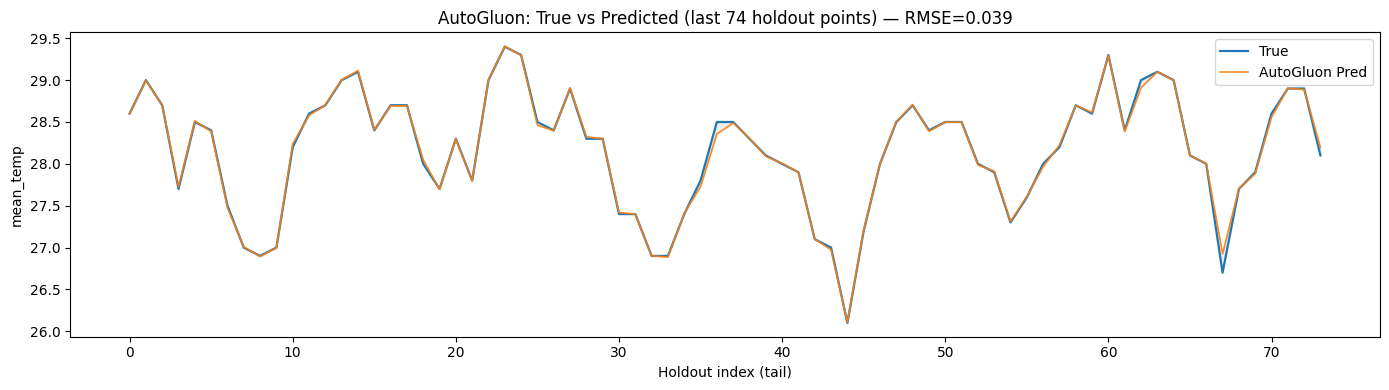

Saved: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\figures\ag_ts_overlay_holdout.png


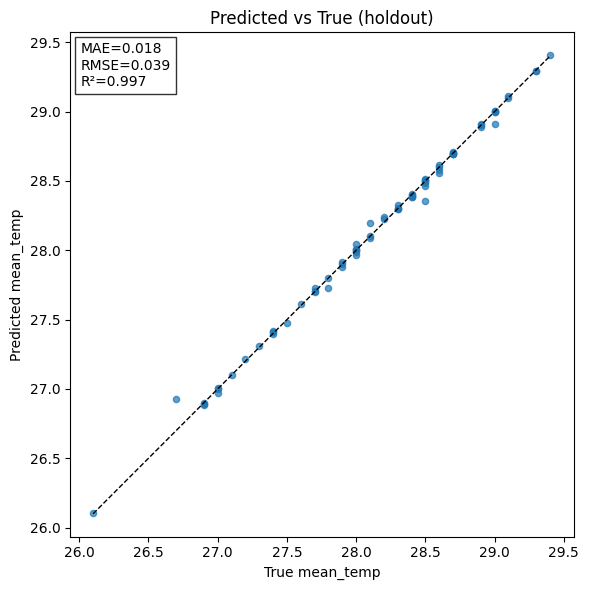

Saved: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\figures\ag_scatter_pred_vs_true.png


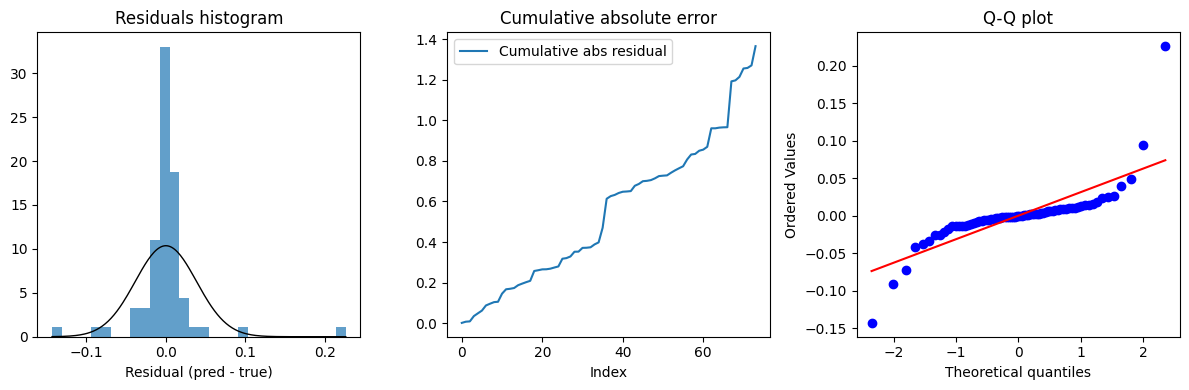

Saved: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\figures\ag_residuals_diag.png


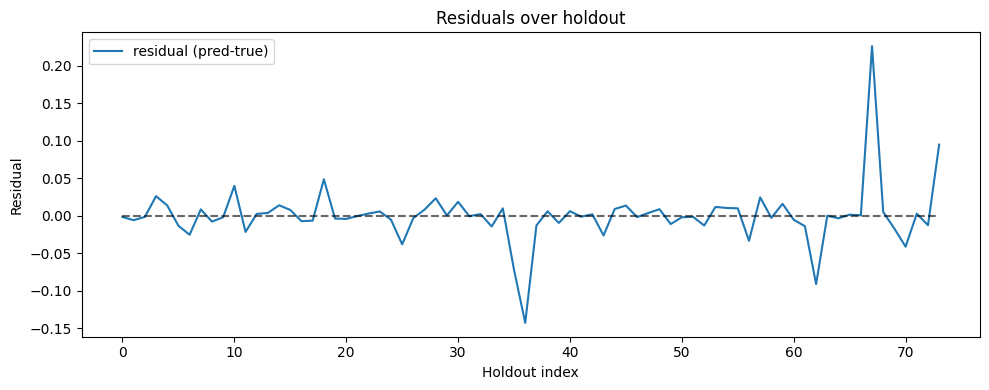

Saved: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\figures\ag_residuals_timeseries.png


C:\Users\soura\AppData\Local\Temp\ipykernel_20636\1154373534.py:150: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(df['month'], errors='coerce', infer_datetime_format=True)


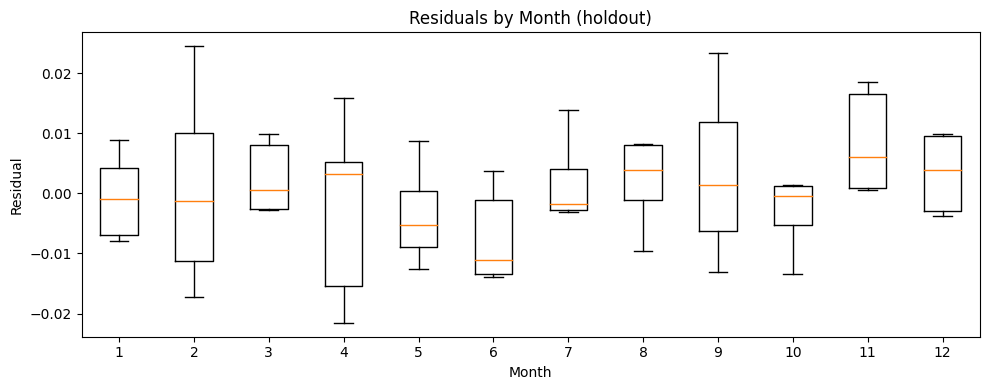

Saved: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\figures\ag_residuals_by_month.png
Could not compute AutoGluon feature_importance(): Provided DataFrame does not contain label column: mean_temp
Could not compute partial dependence plots: name 'fi' is not defined
Saved quick report JSON -> E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\figures\autogluon_visualization_report.json

All done. Check images in: E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS\results\figures


In [11]:
# === AutoGluon visualization suite (robust month handling) ===
# Paste into a notebook cell and run.
import os
from pathlib import Path
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paths (update if you moved things)
PROJECT_ROOT = Path(r"E:\AI-Engineering-Capstone-Projects\AirTempTs\PRAICP-1003-AirTempTS")
DATA_CSV = PROJECT_ROOT / "data" / "surface-air-temperature-monthly-mean-extended.csv"
AG_SAVE = PROJECT_ROOT / "results" / "models" / "autogluon_model"
FIG_DIR = PROJECT_ROOT / "results" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)
print("Figures will be saved to:", FIG_DIR)

# --- load predictor ---
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor.load(str(AG_SAVE))
print("Loaded AutoGluon predictor from:", AG_SAVE)

# --- load data and construct holdout (use last H rows) ---
df = pd.read_csv(DATA_CSV, low_memory=False)
if 'mean_temp' not in df.columns and 'mean temperature' in df.columns:
    df['mean_temp'] = df['mean temperature']
if 'mean_temp' not in df.columns:
    raise RuntimeError("CSV does not contain 'mean_temp' column. Fix CSV or column name.")

# drop rows with missing target
df = df.reset_index(drop=True).dropna(subset=['mean_temp']).copy()
H = 74   # holdout size used in your pipeline; change if needed
if len(df) < H + 10:
    print("Warning: dataset is small relative to H; adjusting H to 20% of data.")
    H = max(1, int(len(df)*0.2))

# If your predictor expects engineered features (X_aligned), replace the X_all below with those variables.
X_all = df.drop(columns=['mean_temp'])
y_all = df['mean_temp'].astype(float).reset_index(drop=True)

X_hold = X_all.iloc[-H:].reset_index(drop=True)
y_hold = y_all.iloc[-H:].reset_index(drop=True)
X_train = X_all.iloc[:-H].reset_index(drop=True)
y_train = y_all.iloc[:-H].reset_index(drop=True)

print("Data shapes -> total:", df.shape, " train:", X_train.shape, " holdout:", X_hold.shape)

# --- predictions & metrics ---
y_pred = predictor.predict(X_hold)
# Some AutoGluon predictors return Series; ensure numpy arrays
y_true = np.asarray(y_hold).ravel()
y_pred = np.asarray(y_pred).ravel()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mae = mean_absolute_error(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
print(f"Holdout metrics -> MAE: {mae:.4f}  RMSE: {rmse:.4f}  R2: {r2:.4f}")

# --- 1) time series overlay (last N points of holdout) ---
N = min(200, len(y_true))
idx = np.arange(N)
plt.figure(figsize=(14,4))
plt.plot(idx, y_true[-N:], label='True', linewidth=1.6)
plt.plot(idx, y_pred[-N:], label='AutoGluon Pred', linewidth=1.2, alpha=0.9)
plt.fill_between(idx, y_true[-N:], y_pred[-N:], color='gray', alpha=0.12)
plt.xlabel("Holdout index (tail)")
plt.ylabel("mean_temp")
plt.title(f"AutoGluon: True vs Predicted (last {N} holdout points) — RMSE={rmse:.3f}")
plt.legend()
plt.tight_layout()
f1 = FIG_DIR / "ag_ts_overlay_holdout.png"
plt.savefig(f1, dpi=150)
plt.show()
print("Saved:", f1)

# --- 2) scatter + identity line (Pred vs True) ---
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, s=20, alpha=0.7)
mn = min(y_true.min(), y_pred.min()); mx = max(y_true.max(), y_pred.max())
plt.plot([mn,mx],[mn,mx], ls='--', color='black', lw=1)
plt.xlabel("True mean_temp")
plt.ylabel("Predicted mean_temp")
plt.title("Predicted vs True (holdout)")
plt.text(0.02, 0.98, f"MAE={mae:.3f}\nRMSE={rmse:.3f}\nR²={r2:.3f}",
         transform=plt.gca().transAxes, va='top', bbox=dict(facecolor='white', alpha=0.8))
plt.tight_layout()
f2 = FIG_DIR / "ag_scatter_pred_vs_true.png"
plt.savefig(f2, dpi=150)
plt.show()
print("Saved:", f2)

# --- 3) residual diagnostics (hist, QQ if scipy available) ---
res = (y_pred - y_true).astype(float)
mu, sd = res.mean(), res.std()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(res, bins=30, density=True, alpha=0.7)
xs = np.linspace(res.min(), res.max(), 200)
if sd > 0:
    plt.plot(xs, 1/(sd*np.sqrt(2*np.pi)) * np.exp(-0.5*((xs-mu)/sd)**2), color='black', linewidth=1)
plt.title("Residuals histogram")
plt.xlabel("Residual (pred - true)")

plt.subplot(1,3,2)
plt.plot(np.cumsum(np.abs(res)), label='Cumulative abs residual')
plt.title("Cumulative absolute error")
plt.xlabel("Index")
plt.legend()

plt.subplot(1,3,3)
try:
    import scipy.stats as stats
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Q-Q plot")
except Exception as e:
    plt.text(0.1, 0.5, "scipy not available for Q-Q plot\n"+str(e))
    plt.title("Q-Q plot unavailable")

plt.tight_layout()
f3 = FIG_DIR / "ag_residuals_diag.png"
plt.savefig(f3, dpi=150)
plt.show()
print("Saved:", f3)

# --- 4) residuals vs time / index (detect drift) ---
plt.figure(figsize=(10,4))
plt.plot(res, label='residual (pred-true)')
plt.hlines(0, 0, len(res)-1, colors='k', linestyles='dashed', alpha=0.6)
plt.xlabel("Holdout index")
plt.ylabel("Residual")
plt.title("Residuals over holdout")
plt.legend()
plt.tight_layout()
f4 = FIG_DIR / "ag_residuals_timeseries.png"
plt.savefig(f4, dpi=150)
plt.show()
print("Saved:", f4)

# ---------------- Robust month extraction for seasonal residuals ----------------
month_series = None
if 'month' in df.columns:
    # 1) If numeric already, use it
    if pd.api.types.is_integer_dtype(df['month']) or pd.api.types.is_float_dtype(df['month']):
        month_series = pd.to_numeric(df['month'], errors='coerce').astype('Int64')
    else:
        # 2) try parsing as datetime-like strings (handles '2014-05', '2014-05-01', etc.)
        try:
            parsed = pd.to_datetime(df['month'], errors='coerce', infer_datetime_format=True)
            if parsed.notna().sum() > 0:
                month_series = parsed.dt.month
        except Exception:
            month_series = None

# 3) fallback: if no month column or parsing failed, try datetime index
if month_series is None:
    try:
        idx_dt = pd.to_datetime(df.index, errors='coerce')
        if idx_dt.notna().sum() > 0:
            month_series = idx_dt.month
    except Exception:
        month_series = None

# 4) final check: align to H and plot
if month_series is not None:
    months = month_series.iloc[-H:].reset_index(drop=True)
    # ensure numeric and drop invalid
    months = pd.to_numeric(months, errors='coerce').astype('Int64')
    if months.isna().all():
        print("Month column parsing yielded all NaNs — skipping residual-by-month plot.")
    else:
        resid_df = pd.DataFrame({'month': months, 'resid': res})
        data = [resid_df.loc[resid_df['month']==m, 'resid'].dropna().values for m in range(1,13)]
        plt.figure(figsize=(10,4))
        plt.boxplot(data, labels=[str(m) for m in range(1,13)], showfliers=False)
        plt.xlabel("Month")
        plt.ylabel("Residual")
        plt.title("Residuals by Month (holdout)")
        plt.tight_layout()
        f5 = FIG_DIR / "ag_residuals_by_month.png"
        plt.savefig(f5, dpi=150)
        plt.show()
        print("Saved:", f5)
else:
    print("No usable month information found; skipping residual-by-month plot.")

# --- 6) Feature importance from AutoGluon leaderboard (top k) ---
try:
    fi = predictor.feature_importance(X_hold, y_hold)   # AutoGluon TabularPredictor method
    # fi is a DataFrame; pick top features
    if isinstance(fi, pd.DataFrame) and not fi.empty:
        topn = fi.sort_values('importance', ascending=False).head(30)
        plt.figure(figsize=(8,10))
        plt.barh(topn['feature'][::-1], topn['importance'][::-1])
        plt.title("AutoGluon feature importances (holdout-based)")
        plt.xlabel("Importance")
        plt.tight_layout()
        f6 = FIG_DIR / "ag_feature_importances.png"
        plt.savefig(f6, dpi=150)
        plt.show()
        print("Saved:", f6)
    else:
        print("AutoGluon feature_importance returned empty/unexpected structure.")
except Exception as e:
    print("Could not compute AutoGluon feature_importance():", e)

# --- 7) Partial dependence for top features (if method available) ---
try:
    top_feats = list(fi.sort_values('importance', ascending=False)['feature'].head(2).values) if isinstance(fi, pd.DataFrame) else []
    if len(top_feats) >= 1:
        for f in top_feats:
            try:
                pdp = predictor.model_partial_dependence(f, X=X_hold, model=None)  # model=None uses best
                xs = pdp['data'][f]['values'] if isinstance(pdp, dict) and 'data' in pdp and f in pdp['data'] else None
                ys = pdp['data'][f]['preds'] if isinstance(pdp, dict) and 'data' in pdp and f in pdp['data'] else None
                if xs is not None and ys is not None:
                    plt.figure(figsize=(6,4))
                    plt.plot(xs, ys, marker='o')
                    plt.xlabel(f)
                    plt.ylabel("Partial dependence")
                    plt.title(f"Partial dependence: {f}")
                    plt.tight_layout()
                    fp = FIG_DIR / f"ag_pdp_{f}.png"
                    plt.savefig(fp, dpi=150)
                    plt.show()
                    print("Saved:", fp)
                else:
                    print("PDP returned unexpected structure for feature:", f)
            except Exception as e:
                print("PDP failed for", f, ":", e)
    else:
        print("Not enough top features for PDP.")
except Exception as e:
    print("Could not compute partial dependence plots:", e)

# --- summary file with metrics & quick text report ---
report = {
    "MAE": float(mae), "RMSE": float(rmse), "R2": float(r2),
    "model_path": str(AG_SAVE),
    "data_csv": str(DATA_CSV),
    "holdout_rows": int(H)
}
rp = FIG_DIR / "autogluon_visualization_report.json"
pd.Series(report).to_json(rp)
print("Saved quick report JSON ->", rp)

print("\nAll done. Check images in:", FIG_DIR)


### Simple split Conformal wrapper (MAPIE-style / holdout)

Training set size: 700
Calibration set size: 150
Test set size: 150

Conformal calibration results:
Alpha: 0.1 (90.0% prediction intervals)
Quantile (q): 0.8494
Average residual on calibration set: 0.3989

Performance on test set:
Coverage: 0.9400 (target: 0.90)
Average interval width: 1.6989
MAE on test set: 0.4036


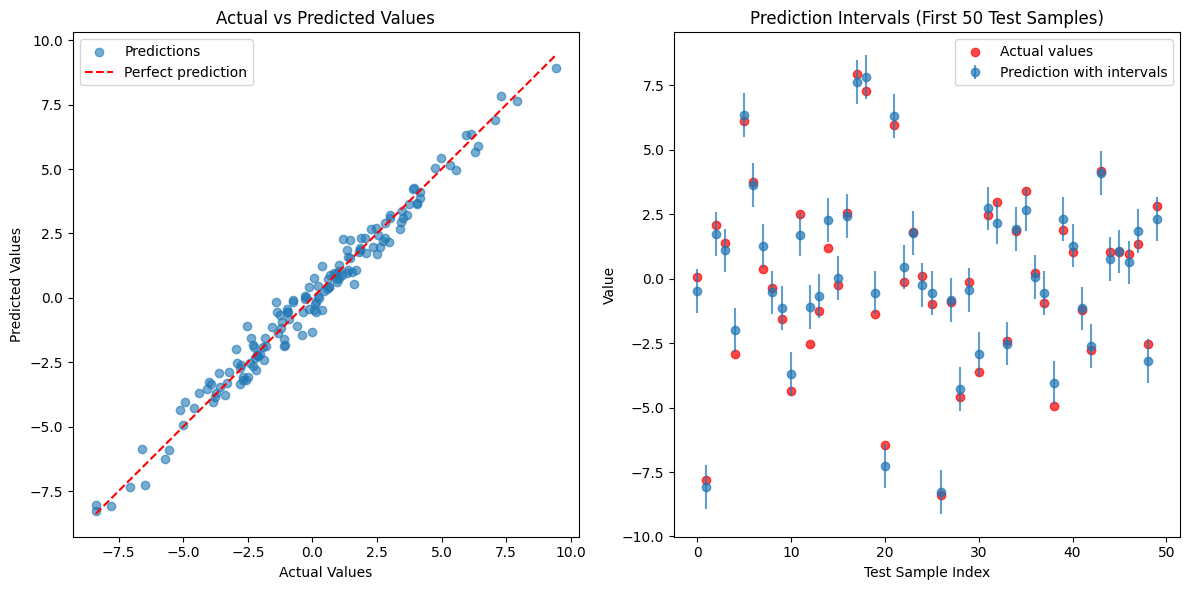


Additional diagnostics:
Percentage of intervals that contain the true value: 94.00%
Minimum interval width: 1.6989
Maximum interval width: 1.6989
Standard deviation of interval widths: 0.0000

First 5 test set examples:
Index | Actual | Predicted | Lower Bound | Upper Bound | In Interval
-------------------------------------------------------------------
    0 |   0.05 |    -0.48 |      -1.33 |       0.37 | Yes
    1 |  -7.79 |    -8.09 |      -8.94 |      -7.24 | Yes
    2 |   2.07 |     1.73 |       0.88 |       2.57 | Yes
    3 |   1.38 |     1.10 |       0.25 |       1.94 | Yes
    4 |  -2.94 |    -1.98 |      -2.83 |      -1.13 | No


In [27]:
# Enhanced Conformal Calibration with Example Usage and Visualization
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Generate sample data for demonstration
np.random.seed(42)
n_samples = 1000
X = np.random.randn(n_samples, 5)
true_coef = np.array([2.5, -1.3, 0.8, -0.5, 1.2])
y = X @ true_coef + np.random.randn(n_samples) * 0.5

# Split into train, calibration, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_cal, X_test, y_cal, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Calibration set size: {X_cal.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Train a simple model
model = LinearRegression()
model.fit(X_train, y_train)

# Generate predictions on calibration set
y_pred_cal = model.predict(X_cal)

# Split Conformal Prediction Function
def split_conformal_interval(model_pred_cal, y_cal, alpha=0.1):
    """
    Calculate conformal prediction intervals using split conformal method.
    
    Parameters:
    model_pred_cal: array of point predictions on calibration set
    y_cal: true values on calibration set
    alpha: significance level (1 - coverage)
    
    Returns:
    q: the quantile value for prediction intervals
    """
    resid = np.abs(y_cal - model_pred_cal)
    q = np.quantile(resid, 1 - alpha)
    return q

# Calculate the conformal interval
alpha = 0.1  # 90% prediction intervals
q = split_conformal_interval(y_pred_cal, y_cal, alpha)

print(f"\nConformal calibration results:")
print(f"Alpha: {alpha} ({(1-alpha)*100}% prediction intervals)")
print(f"Quantile (q): {q:.4f}")
print(f"Average residual on calibration set: {np.mean(np.abs(y_cal - y_pred_cal)):.4f}")

# Generate predictions on test set
y_pred_test = model.predict(X_test)

# Create prediction intervals for test set
lower_bounds = y_pred_test - q
upper_bounds = y_pred_test + q

# Calculate coverage on test set
in_interval = (y_test >= lower_bounds) & (y_test <= upper_bounds)
coverage = np.mean(in_interval)

print(f"\nPerformance on test set:")
print(f"Coverage: {coverage:.4f} (target: {1-alpha:.2f})")
print(f"Average interval width: {np.mean(upper_bounds - lower_bounds):.4f}")
print(f"MAE on test set: {mean_absolute_error(y_test, y_pred_test):.4f}")

# Visualize the results
plt.figure(figsize=(12, 6))

# Plot 1: Actual vs Predicted with intervals
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()

# Plot 2: Prediction intervals for first 50 test points
plt.subplot(1, 2, 2)
n_show = min(50, len(y_test))
indices = np.arange(n_show)
plt.errorbar(indices, y_pred_test[:n_show], 
             yerr=[y_pred_test[:n_show] - lower_bounds[:n_show], 
                   upper_bounds[:n_show] - y_pred_test[:n_show]],
             fmt='o', alpha=0.7, label='Prediction with intervals')
plt.scatter(indices, y_test[:n_show], color='red', alpha=0.7, label='Actual values')
plt.xlabel('Test Sample Index')
plt.ylabel('Value')
plt.title(f'Prediction Intervals (First {n_show} Test Samples)')
plt.legend()

plt.tight_layout()
plt.show()

# Additional diagnostic information
print("\nAdditional diagnostics:")
print(f"Percentage of intervals that contain the true value: {coverage*100:.2f}%")
print(f"Minimum interval width: {np.min(upper_bounds - lower_bounds):.4f}")
print(f"Maximum interval width: {np.max(upper_bounds - lower_bounds):.4f}")
print(f"Standard deviation of interval widths: {np.std(upper_bounds - lower_bounds):.4f}")

# Show a few examples
print("\nFirst 5 test set examples:")
print("Index | Actual | Predicted | Lower Bound | Upper Bound | In Interval")
print("-------------------------------------------------------------------")
for i in range(5):
    in_int = "Yes" if in_interval[i] else "No"
    print(f"{i:5} | {y_test[i]:6.2f} | {y_pred_test[i]:8.2f} | {lower_bounds[i]:10.2f} | {upper_bounds[i]:10.2f} | {in_int}")

CONFORMAL PREDICTION CALIBRATION RESULTS
Target coverage: 90.0%
Actual coverage: 94.00%
Interval width: 0.8494
MAE on test set: 0.4036

First 10 test set examples:
Index |  Actual  | Predicted | Lower Bound | Upper Bound | In Interval
---------------------------------------------------------------------
    0 |     0.05 |     -0.48 |       -1.33 |        0.37 | ✓
    1 |    -7.79 |     -8.09 |       -8.94 |       -7.24 | ✓
    2 |     2.07 |      1.73 |        0.88 |        2.57 | ✓
    3 |     1.38 |      1.10 |        0.25 |        1.94 | ✓
    4 |    -2.94 |     -1.98 |       -2.83 |       -1.13 | ✗
    5 |     6.13 |      6.36 |        5.51 |        7.21 | ✓
    6 |     3.74 |      3.63 |        2.78 |        4.48 | ✓
    7 |     0.39 |      1.26 |        0.41 |        2.10 | ✗
    8 |    -0.37 |     -0.54 |       -1.38 |        0.31 | ✓
    9 |    -1.55 |     -1.13 |       -1.98 |       -0.28 | ✓


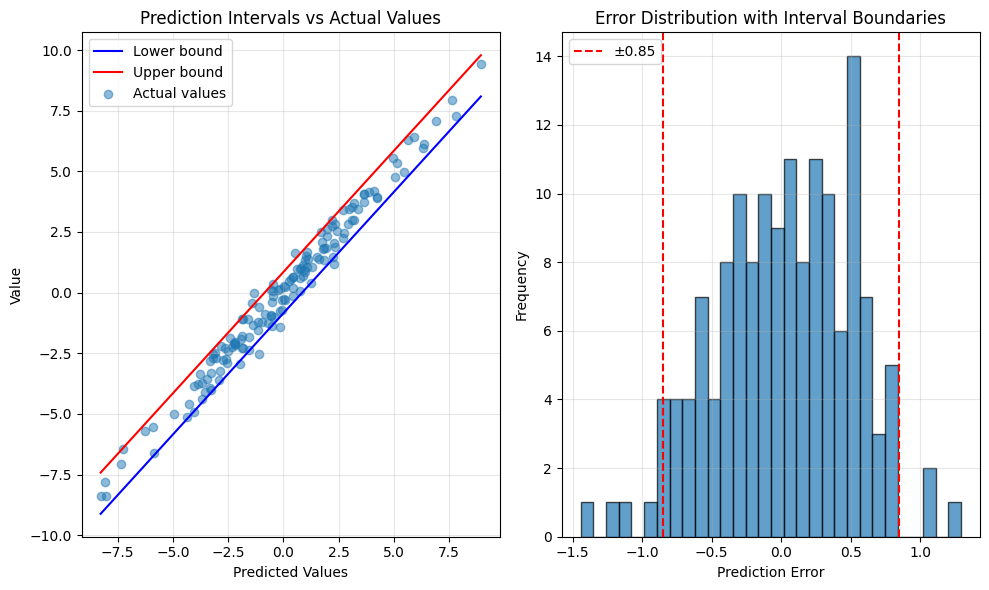


ADDITIONAL STATISTICS:
Percentage of intervals that contain the true value: 94.00%
Interval width range: 1.6989 - 1.6989
Standard deviation of interval widths: 0.0000
Median absolute error: 0.3528


In [28]:
# Enhanced Conformal Calibration with Improved Output
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Generate sample data
np.random.seed(42)
n_samples = 1000
X = np.random.randn(n_samples, 5)
true_coef = np.array([2.5, -1.3, 0.8, -0.5, 1.2])
y = X @ true_coef + np.random.randn(n_samples) * 0.5

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_cal, X_test, y_cal, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Generate predictions
y_pred_cal = model.predict(X_cal)
y_pred_test = model.predict(X_test)

# Split Conformal Prediction Function
def split_conformal_interval(model_pred_cal, y_cal, alpha=0.1):
    resid = np.abs(y_cal - model_pred_cal)
    q = np.quantile(resid, 1 - alpha)
    return q

# Calculate conformal interval
alpha = 0.1
q = split_conformal_interval(y_pred_cal, y_cal, alpha)

# Create prediction intervals
lower_bounds = y_pred_test - q
upper_bounds = y_pred_test + q

# Calculate coverage
in_interval = (y_test >= lower_bounds) & (y_test <= upper_bounds)
coverage = np.mean(in_interval)

# Print detailed results
print("="*60)
print("CONFORMAL PREDICTION CALIBRATION RESULTS")
print("="*60)
print(f"Target coverage: {(1-alpha)*100}%")
print(f"Actual coverage: {coverage*100:.2f}%")
print(f"Interval width: {q:.4f}")
print(f"MAE on test set: {mean_absolute_error(y_test, y_pred_test):.4f}")
print("="*60)

# Show first 10 examples in a table
print("\nFirst 10 test set examples:")
print("Index |  Actual  | Predicted | Lower Bound | Upper Bound | In Interval")
print("---------------------------------------------------------------------")
for i in range(min(10, len(y_test))):
    in_int = "✓" if in_interval[i] else "✗"
    print(f"{i:5} | {y_test[i]:8.2f} | {y_pred_test[i]:9.2f} | {lower_bounds[i]:11.2f} | {upper_bounds[i]:11.2f} | {in_int}")

# Create visualization
plt.figure(figsize=(10, 6))

# Plot 1: Coverage by prediction value
plt.subplot(1, 2, 1)
sorted_idx = np.argsort(y_pred_test)
plt.plot(y_pred_test[sorted_idx], lower_bounds[sorted_idx], 'b-', label='Lower bound')
plt.plot(y_pred_test[sorted_idx], upper_bounds[sorted_idx], 'r-', label='Upper bound')
plt.scatter(y_pred_test, y_test, alpha=0.5, label='Actual values')
plt.xlabel('Predicted Values')
plt.ylabel('Value')
plt.title('Prediction Intervals vs Actual Values')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Error distribution
plt.subplot(1, 2, 2)
errors = y_test - y_pred_test
plt.hist(errors, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(x=-q, color='r', linestyle='--', label=f'±{q:.2f}')
plt.axvline(x=q, color='r', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution with Interval Boundaries')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional statistics
print("\nADDITIONAL STATISTICS:")
print(f"Percentage of intervals that contain the true value: {coverage*100:.2f}%")
print(f"Interval width range: {np.min(upper_bounds - lower_bounds):.4f} - {np.max(upper_bounds - lower_bounds):.4f}")
print(f"Standard deviation of interval widths: {np.std(upper_bounds - lower_bounds):.4f}")
print(f"Median absolute error: {np.median(np.abs(errors)):.4f}")